In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from pathlib import Path
import sys
from utils import *

# project root = parent of the notebooks/ folder
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from scipy.spatial.distance import cdist
from tqdm import tqdm
from config import Config, Config2
from template import LLAMA3_CHAT_TEMPLATE
from typing import Dict, Tuple
from peft import PeftModel
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from kmeans_pytorch import kmeans
import torch.nn.functional as F
import json
import re
import time

In [ ]:
cfg = Config2()
model_id = cfg.model_id
print(model_id)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(cfg.model_id)
tokenizer.pad_token = '<|finetune_right_pad_id|>'
model = AutoModelForCausalLM.from_pretrained(cfg.model_id, torch_dtype=torch.bfloat16, attn_implementation = 'flash_attention_2')
model = model.to('cuda')

In [ ]:
def make_template_format(df):
     df['question_f'] = df['question'].apply(lambda x : LLAMA3_CHAT_TEMPLATE.format(question = x))
     df['answer_f'] = df['answer'].apply(lambda x : x + tokenizer.eos_token)  
     return df

In [ ]:
def get_hidden_states_last_token(
    df, model, tokenizer, device, batch_size=1,
    max_length: int = 512
):
    """
    Returns a (N, H) array of penultimate-layer embeddings corresponding to the
    LAST non-padding token of each sequence.

    Args:
        df (pd.DataFrame): DataFrame with 'question_f' and 'answer_f' columns.
        model: The Hugging Face model.
        tokenizer: The Hugging Face tokenizer.
        device: The torch device ('cuda', 'cpu', etc.).
        batch_size (int): The batch size for processing.
        max_length (int): The maximum sequence length for the tokenizer.

    Returns:
        np.ndarray: A NumPy array of shape (N, H) where N is the number of
                    texts and H is the hidden size of the model.
    """
    # Combine question and answer to form the input text
    texts = (df['question_f'] + df['answer_f']).tolist()
    all_embeddings = []

    model.eval()
    print('Now extracting last-token hidden reps from the penultimate layer')

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            return_tensors='pt',
            max_length=max_length
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Penultimate hidden states, shape: (B, T, H)
        # B = batch_size, T = sequence_length, H = hidden_size
        penultimate_hidden_states = outputs.hidden_states[-2]

        # Find the index of the last non-padding token for each sequence
        # The length of each sequence is the sum of its attention mask
        sequence_lengths = inputs['attention_mask'].sum(dim=1)
        
        # The index of the last token is the length - 1
        last_token_indices = sequence_lengths - 1

        # We need to select the hidden state at the `last_token_indices` for each
        # item in the batch. We can use advanced indexing for this.
        # Create a tensor of batch indices: [0, 1, 2, ...]
        batch_indices = torch.arange(len(penultimate_hidden_states), device=device)
        
        # Index the hidden states tensor to get the last token's representation
        # for each sequence in the batch.
        last_token_embeddings = penultimate_hidden_states[batch_indices, last_token_indices]
        
        # Move to CPU and convert to numpy array
        all_embeddings.append(last_token_embeddings.float().cpu().numpy())

    return np.vstack(all_embeddings)


def get_reps_last_token(df, model, tokenizer, device, batch_size=1, **kwargs):
    """
    Wrapper that returns a dataframe with a 'representation' column
    containing last-token embeddings.
    kwargs are passed to get_hidden_states_last_token.
    """
    embeddings = get_hidden_states_last_token(
        df=df, model=model, tokenizer=tokenizer, device=device,
        batch_size=batch_size, **kwargs
    )
    annotated_df = df.copy()
    # Store the numpy arrays as objects in the DataFrame column
    annotated_df['representation_lt'] = list(embeddings)
    return annotated_df

In [ ]:
df = pd.read_csv('./data/mix/full_data.csv')

In [ ]:
df = make_template_format(df)
df = get_reps_last_token(df=df, model=model, tokenizer=tokenizer, device=torch.device('cuda'), batch_size=32)

In [6]:
df['type'].value_counts()

type
retain      19875
test          538
forget        380
forget_1       98
Name: count, dtype: int64

In [ ]:
reps = np.vstack(df['representation_lt'].to_numpy())

In [10]:
start_time = time.time()
all_reps_tensor = torch.from_numpy(reps).to(dtype=torch.float64)
end_time = time.time()

In [11]:
print(f"Conversion to PyTorch tensor took: {end_time - start_time:.4f} seconds.")
print(f"Shape of PyTorch tensor: {all_reps_tensor.shape}")

Conversion to PyTorch tensor took: 0.0695 seconds.
Shape of PyTorch tensor: torch.Size([20891, 4096])


In [ ]:
torch.save(all_reps_tensor, 'mix_reps_lt.pt')

In [12]:
from sklearn.cluster import KMeans

In [ ]:
N_CLUSTERS = 10
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
initial_reps = np.vstack(df['representation_lt'].to_numpy())
df['cluster'] = kmeans.fit_predict(initial_reps)

print(f"Data clustered into {N_CLUSTERS} clusters.")
print("\n" + "="*50 + "\n")

In [15]:
df.dtypes

id            object
question      object
answer        object
source        object
type          object
num_tokens     int64
reps          object
cluster        int64
dtype: object

In [16]:
def get_df(df, ret_path):
    ret = pd.read_csv(ret_path)
    df['type2'] = 'other'
    df.loc[df['id'].isin(ret['id']), 'type2'] = 'retain'
    df.loc[df['type'] == 'forget_1', 'type2'] = 'forget_1'

    return df

In [17]:
device = 'cuda'

### initial heuristics

In [19]:
def calculate_variance(reps, device='cuda', dtype=torch.float64):
    # Your original, correct calculate_variance function
    if not isinstance(reps, torch.Tensor):
        X = torch.as_tensor(reps, dtype=dtype, device=device)
    else:
        X = reps.to(device=device, dtype=dtype)
    n = X.shape[0]
    if n < 2: return float("nan")
    Xn = F.normalize(X, p=2, dim=1)
    v = Xn.sum(dim=0)
    sumsq = n
    sum_upper_sim = 0.5 * (v.dot(v) - sumsq)
    m = n * (n - 1) / 2.0
    mean_dist = 1.0 - (sum_upper_sim / m)
    return float(mean_dist.item())

def calculate_statistical_variance(reps, device='cuda', dtype=torch.float64):
    """
    Calculates the statistical variance of a set of representations.
    This is the PyTorch equivalent of np.variance.
    """
    if not isinstance(reps, torch.Tensor):
        X = torch.as_tensor(reps, dtype=dtype, device=device)
    else:
        X = reps.to(device=device, dtype=dtype)
        
    n = X.shape[0]
    if n < 2:
        return float("nan")

    # 1. Calculate the variance for each dimension across all samples.
    # The 'dim=0' argument computes variance along the rows (samples).
    variance_per_dimension = torch.var(X, dim=0)

    # 2. Calculate the mean of the variances across all dimensions
    # to get a single scalar value representing the overall variance.
    mean_variance = torch.mean(variance_per_dimension)

    return float(mean_variance.item())

In [20]:
def get_variance(df):
    df_ret = df[df['type2'] == 'retain']
    if not df_ret.empty:
        avg_div_ret = calculate_variance(np.vstack(df_ret['reps'].to_numpy()), device=device) 
    else:
        avg_div_ret = 0.0
    
    df_f = df[df['type2'] == 'forget_1']
    if not df_f.empty:
        avg_div_f = calculate_variance(np.vstack(df_f['reps'].to_numpy()), device=device)
    else:
        avg_div_f = 0.0

    df_o = df[df['type2'] != 'forget_1']
    avg_div_o = calculate_variance(np.vstack(df_o['reps'].to_numpy()), device=device) if not df_o.empty else float('nan')
    avg_div_full = calculate_variance(np.vstack(df['reps'].to_numpy()), device=device) if not df.empty else float('nan')

    return avg_div_ret, avg_div_f, avg_div_o, avg_div_full

In [21]:
def get_variance_fast(df, device='cuda'):
    """
    A much faster version of get_variance.
    It converts the 'reps' data to a tensor once, then uses efficient
    slicing to perform calculations.
    """
    if df.empty:
        return float('nan'), float('nan'), float('nan'), float('nan')
    all_reps_tensor = torch.tensor(np.array(df['reps'].tolist()), device=device)


    is_retain = torch.tensor((df['type2'] == 'retain').values, device=device)
    is_forget = torch.tensor((df['type2'] == 'forget_1').values, device=device)
    is_other = torch.tensor((df['type2'] == 'other').values, device=device)
    reps_ret = all_reps_tensor[is_retain]
    avg_div_ret = calculate_variance(reps_ret) if reps_ret.shape[0] > 0 else 0.0

    reps_f = all_reps_tensor[is_forget]
    avg_div_f = calculate_variance(reps_f) if reps_f.shape[0] > 0 else 0.0

    reps_o = all_reps_tensor[is_other]
    avg_div_o = calculate_variance(reps_o) if reps_o.shape[0] > 0 else float('nan')

    avg_div_full = calculate_variance(all_reps_tensor)

    return avg_div_ret, avg_div_f, avg_div_o, avg_div_full

In [24]:
def get_variance_from_tensor(df, all_reps_tensor, device='cuda'):
    """
    Calculates variance using a pre-computed tensor. This is extremely fast.
    """
    if df.empty:
        return float('nan'), float('nan'), float('nan'), float('nan')
    
    all_reps_tensor_gpu = all_reps_tensor.to(device)
    is_retain = (df['type2'] == 'retain').values
    is_forget = (df['type2'] == 'forget_1').values
    is_other = (df['type2'] == 'other').values
    
    reps_ret = all_reps_tensor_gpu[is_retain]
    avg_div_ret = calculate_variance(reps_ret, device=device) if reps_ret.shape[0] > 0 else 0.0
    reps_f = all_reps_tensor_gpu[is_forget]
    avg_div_f = calculate_variance(reps_f, device=device) if reps_f.shape[0] > 0 else 0.0
    reps_o = all_reps_tensor_gpu[is_other]
    avg_div_o = calculate_variance(reps_o, device=device) if reps_o.shape[0] > 0 else float('nan')
    avg_div_full = calculate_variance(all_reps_tensor_gpu, device=device)
    return avg_div_ret, avg_div_f, avg_div_o, avg_div_full

def get_statistical_variance_from_tensor(df, all_reps_tensor, device='cuda'):
    """
    Calculates the mean statistical variance using a pre-computed tensor.
    This is the correct way to calculate variance similar to np.variance.
    """
    if df.empty:
        return float('nan'), float('nan'), float('nan'), float('nan')
    
    all_reps_tensor_gpu = all_reps_tensor.to(device)
    
    # Use boolean arrays from pandas for indexing, which is often cleaner
    is_retain = (df['type2'] == 'retain').values
    is_forget = (df['type2'] == 'forget_1').values
    is_other = (df['type2'] == 'other').values # Note: 'other' seems to be a new category in your code
    
    # --- Retain Set ---
    reps_ret = all_reps_tensor_gpu[is_retain]
    avg_var_ret = calculate_statistical_variance(reps_ret, device=device) if reps_ret.shape[0] > 0 else 0.0

    # --- Forget Set ---
    reps_f = all_reps_tensor_gpu[is_forget]
    avg_var_f = calculate_statistical_variance(reps_f, device=device) if reps_f.shape[0] > 0 else 0.0

    # --- Other Set ---
    reps_o = all_reps_tensor_gpu[is_other]
    avg_var_o = calculate_statistical_variance(reps_o, device=device) if reps_o.shape[0] > 0 else float('nan')

    # --- Full Set ---
    avg_var_full = calculate_statistical_variance(all_reps_tensor_gpu, device=device)
    
    return avg_var_ret, avg_var_f, avg_var_o, avg_var_full


In [25]:
def get_risk_map(df):
    cluster_totals = df['cluster'].value_counts()

    forget_df = df[df['type2'] == 'forget_1']
    forget_counts = forget_df['cluster'].value_counts()

    cluster_ratios_df = pd.DataFrame({
        'total_count': cluster_totals,
        'forget_count': forget_counts.reindex(cluster_totals.index).fillna(0)
    })
    cluster_ratios_df['forget_ratio'] = cluster_ratios_df['forget_count'] / cluster_ratios_df['total_count']
    cluster_forget_ratios = cluster_ratios_df['forget_ratio']

    return cluster_forget_ratios

In [26]:
def calculate_contamination_score(retain_set_df, risk_map):
    """
    Calculates the contamination score for a given retain set.
    
    Args:
        retain_set_df (pd.DataFrame): DataFrame containing the samples of one retain set.
                                      Must have a 'cluster_label' column.
        risk_map (pd.Series): A Series mapping cluster_label to its forget_ratio.
    
    Returns:
        float: The contamination score for the retain set.
    """
    if retain_set_df.empty:
        return 0.0

    sample_risks = retain_set_df['cluster'].map(risk_map)

    contamination_score = sample_risks.mean()
    
    return contamination_score

In [27]:
def contamination_score(df: pd.DataFrame):
    retain_cluster_df = df.loc[df['type2'] == 'retain']
    cluster_forget_ratios = get_risk_map(df)
    score = calculate_contamination_score(retain_cluster_df, cluster_forget_ratios)
    return score

In [28]:
def get_memories(df: pd.DataFrame):
    avg_mem = df['ori_mem'].mean()
    avg_ret_mem = df[df['type2'] == 'retain']['ori_mem'].mean()
    avg_f_mem = df[df['type2'] == 'forget_1']['ori_mem'].mean()
    avg_o_mem = df[df['type2'] == 'other']['ori_mem'].mean()
    return avg_mem, avg_ret_mem, avg_f_mem, avg_o_mem

def relative_utility_drop(new_utility: float, actual_utility: float = 0.75):
    return round(((actual_utility - new_utility) / actual_utility)*100, 2)

In [29]:
from typing import Dict, Any
def _safe_percent(vc: pd.Series, key: str) -> float:
    """Return normalized frequency for `key` or 0.0 if missing."""
    try:
        return float(vc.get(key, 0.0))
    except Exception:
        return 0.0

def _upsert_metrics_row(row: Dict[str, Any], csv_path: str, jsonl_path: str, key: str = 'ret_id') -> pd.DataFrame:
    """Upsert a single row into a CSV (by `key`), mirror to JSONL, and return the full DataFrame."""
    if os.path.exists(csv_path):
        log_df = pd.read_csv(csv_path)
    else:
        log_df = pd.DataFrame()

    for col in row.keys():
        if col not in log_df.columns:
            log_df[col] = pd.NA

    for col in log_df.columns:
        if col not in row:
            row[col] = pd.NA
            
    if key in log_df.columns and log_df.shape[0] > 0 and str(row[key]) in set(log_df[key].astype(str)):
        idx = log_df.index[log_df[key].astype(str) == str(row[key])][0]
        for k, v in row.items():
            log_df.at[idx, k] = v
    else:
        log_df = pd.concat([log_df, pd.DataFrame([row])], ignore_index=True)

    log_df.to_csv(csv_path, index=False)
    with open(jsonl_path, 'w', encoding='utf-8') as f:
        for rec in log_df.to_dict(orient='records'):
            f.write(json.dumps(rec) + "\n")

    return log_df

In [ ]:
LOG_CSV   = "unlearning_metrics_mix.csv"
LOG_JSONL = "unlearning_metrics_mix.jsonl"

In [31]:
def get_pre_unlearning_heursistics(df, all_reps_tensor, ret_path, ret_id, new_utility, data, fq:float, baseline_utility: float = 0.75):
    
    df = get_df(df, ret_path)
    vc = df['type2'].value_counts(normalize=True)
    print(df['type2'].value_counts())
    forget_percent = _safe_percent(vc, 'forget_1')
    retain_percent = _safe_percent(vc, 'retain')

    ret_len   = int((df['type2'] == 'retain').sum())
    total_len = int(len(df))

    start_time = time.time()
    avg_var_ret, avg_var_f, avg_var_o, avg_var_full = get_statistical_variance_from_tensor(df, all_reps_tensor, device='cuda')
    end_time = time.time()
    print(f"Variance calculation took: {end_time - start_time:.4f} seconds!")
    cont_score = contamination_score(df) 
    rel_utility_drop = relative_utility_drop(new_utility, actual_utility=baseline_utility)

    
    row = {
        "dataset" : data,
        "ret_id": ret_id,
        "new_utility": float(new_utility),
        "baseline_utility": float(baseline_utility),
        "forget_percent": float(forget_percent),
        "retain_percent": float(retain_percent),
        "ret_len": ret_len,
        "total_len": total_len,
        "avg_var_ret": float(avg_var_ret),
        "avg_var_f": float(avg_var_f),
        "avg_var_o": float(avg_var_o),
        "avg_var_full": float(avg_var_full),
        "contamination_score": float(cont_score),
        "relative_utility_drop": float(rel_utility_drop),
        "fq" : float(fq),
    }

    
    log_df = _upsert_metrics_row(row, csv_path=LOG_CSV, jsonl_path=LOG_JSONL, key="ret_id")
    return row, log_df

In [32]:
def get_metrics_df(csv_path: str = LOG_CSV) -> pd.DataFrame:
    """Convenience: load the whole metrics log as a DataFrame for analysis."""
    if not os.path.exists(csv_path):
        return pd.DataFrame()
    return pd.read_csv(csv_path)

In [ ]:
all_reps_tensor = torch.load('/mix_reps_lt.pt')

/home/praveen/tmp/ipykernel_2603070/4127292548.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_reps_tensor = torch.load('/home/praveen/coreset/reps/reps/unified/reps

In [ ]:

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/grand/grad_difference/diff_20.csv", 
                                             ret_id="diff_20", data = "mix",
                                             fq = 0.93,
                                             new_utility=0.50)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/grand/grad_difference/diff_10.csv", 
                                             ret_id="diff_10", data = "mix",
                                             fq = 0.95,
                                             new_utility=0.40)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/grand/grad_difference/diff_5.csv", 
                                             ret_id="diff_5", data = "mix",
                                             fq = 0.95,
                                             new_utility=0.21)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/grand/grad_descent/desc_20.csv", 
                                             ret_id="desc_20", data = "mix",
                                             fq = 0.94,
                                             new_utility=0.46)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/grand/grad_descent/desc_10.csv", 
                                             ret_id="desc_10", data = "mix",
                                             fq = 0.95,
                                             new_utility=0.35)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/grand/grad_descent/desc_5.csv", 
                                             ret_id="desc_5", data = "mix",
                                             fq = 0.94,
                                             new_utility=0.13)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/moderate/mod_5.csv", 
                                             ret_id="mod_5", data = "mix",
                                             fq = 0.94,
                                             new_utility=0.41)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/moderate/mod_10.csv", 
                                             ret_id="mod_10", data = "mix",
                                             fq = 0.93,
                                             new_utility=0.49)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/moderate/mod_20.csv", 
                                             ret_id="mod_20", data = "mix",
                                             fq = 0.93,
                                             new_utility=0.58)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/random/random_5.csv", 
                                             ret_id="random_5", data = "mix",
                                             fq = 0.92,
                                             new_utility=0.59)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/random/random_10.csv", 
                                             ret_id="random_10", data = "mix",
                                             fq = 0.93,
                                             new_utility=0.50)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/random/random_20.csv", 
                                             ret_id="random_20", data = "mix",
                                             fq = 0.93,
                                             new_utility=0.55)

type2
other       16635
retain       4158
forget_1       98
Name: count, dtype: int64


Variance calculation took: 0.5787 seconds!
type2
other       18714
retain       2079
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0958 seconds!
type2
other       19754
retain       1039
forget_1       98
Name: count, dtype: int64


/home/praveen/tmp/ipykernel_2603070/1264738245.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([row])], ignore_index=True)


Variance calculation took: 0.0769 seconds!
type2
other       16635
retain       4158
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0773 seconds!
type2
other       18714
retain       2079
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0782 seconds!
type2
other       19754
retain       1039
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0781 seconds!
type2
other       19756
retain       1037
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0771 seconds!
type2
other       18716
retain       2077
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0774 seconds!
type2
other       16637
retain       4156
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0780 seconds!
type2
other       19753
retain       1040
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0779 seconds!
type2
other       18714
retain       2079
forget_1    

In [35]:
metrics = get_metrics_df()

In [37]:
from scipy.stats import pearsonr, spearmanr

In [38]:
metrics.head()

,dataset,ret_id,new_utility,baseline_utility,forget_percent,retain_percent,ret_len,total_len,avg_var_ret,avg_var_f,avg_var_o,avg_var_full,contamination_score,relative_utility_drop,fq
0,unified,diff_20,0.50,0.75,0.004691,0.199033,4158,20891,0.051587,0.026133,0.044658,0.046868,0.007072,33.33,0.93
1,unified,diff_10,0.40,0.75,0.004691,0.099517,2079,20891,0.054540,0.026133,0.045638,0.046868,0.009829,46.67,0.95
2,unified,diff_5,0.21,0.75,0.004691,0.049734,1039,20891,0.055337,0.026133,0.046257,0.046868,0.015349,72.00,0.95
3,unified,desc_20,0.46,0.75,0.004691,0.199033,4158,20891,0.049513,0.026133,0.044406,0.046868,0.001660,38.67,0.94
4,unified,desc_10,0.35,0.75,0.004691,0.099517,2079,20891,0.051916,0.026133,0.045397,0.046868,0.001887,53.33,0.95


In [39]:
metrics['ret_id'].unique()

array(['diff_20', 'diff_10', 'diff_5', 'desc_20', 'desc_10', 'desc_5',
       'mod_5', 'mod_10', 'mod_20', 'random_5', 'random_10', 'random_20'],
      dtype=object)

### Images

In [40]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
metrics = pd.read_csv('unlearning_metrics_mix.csv')

In [14]:
print("--- DataFrame Shape ---")
print(f"The metrics DataFrame has {metrics.shape[0]} rows and {metrics.shape[1]} columns.\n")

# Check for the number of unique values in each column
print("--- Unique Value Counts ---")
print(f"Unique values in 'relative_utility_drop': {metrics['relative_utility_drop'].nunique()}")
print(f"Unique values in 'avg_var_o': {metrics['avg_var_o'].nunique()}\n")


# A very powerful way to check is with .describe()
print("--- Descriptive Statistics ---")
print(metrics[["relative_utility_drop", "avg_var_o"]].describe())

--- DataFrame Shape ---
The metrics DataFrame has 12 rows and 15 columns.

--- Unique Value Counts ---
Unique values in 'relative_utility_drop': 11
Unique values in 'avg_var_o': 12

--- Descriptive Statistics ---
       relative_utility_drop  avg_var_o
count              12.000000  12.000000
mean               42.555833   0.147821
std                18.980062   0.004036
min                21.330000   0.140222
25%                31.665000   0.145520
50%                36.670000   0.149103
75%                48.335000   0.150243
max                82.670000   0.153670


In [43]:
cols_to_correlate = metrics.columns.drop(['dataset', 'ret_id', 'baseline_utility', 'forget_percent', 'total_len', 'avg_var_full', 'avg_var_f', 'new_utility', 'ret_len', 'contamination_score'])

# Initialize matrices for Pearson correlations and p-values
pearson_corr_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                   index=cols_to_correlate, columns=cols_to_correlate)
pearson_p_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                index=cols_to_correlate, columns=cols_to_correlate)

# Initialize matrices for Spearman correlations and p-values
spearman_corr_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                    index=cols_to_correlate, columns=cols_to_correlate)
spearman_p_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                 index=cols_to_correlate, columns=cols_to_correlate)

# Calculate correlations and p-values
for col1 in cols_to_correlate:
    for col2 in cols_to_correlate:
        # Pearson
        pearson_corr, pearson_p = pearsonr(metrics[col1], metrics[col2])
        pearson_corr_matrix.loc[col1, col2] = pearson_corr
        pearson_p_matrix.loc[col1, col2] = pearson_p
        
        # Spearman
        spearman_corr, spearman_p = spearmanr(metrics[col1], metrics[col2])
        spearman_corr_matrix.loc[col1, col2] = spearman_corr
        spearman_p_matrix.loc[col1, col2] = spearman_p


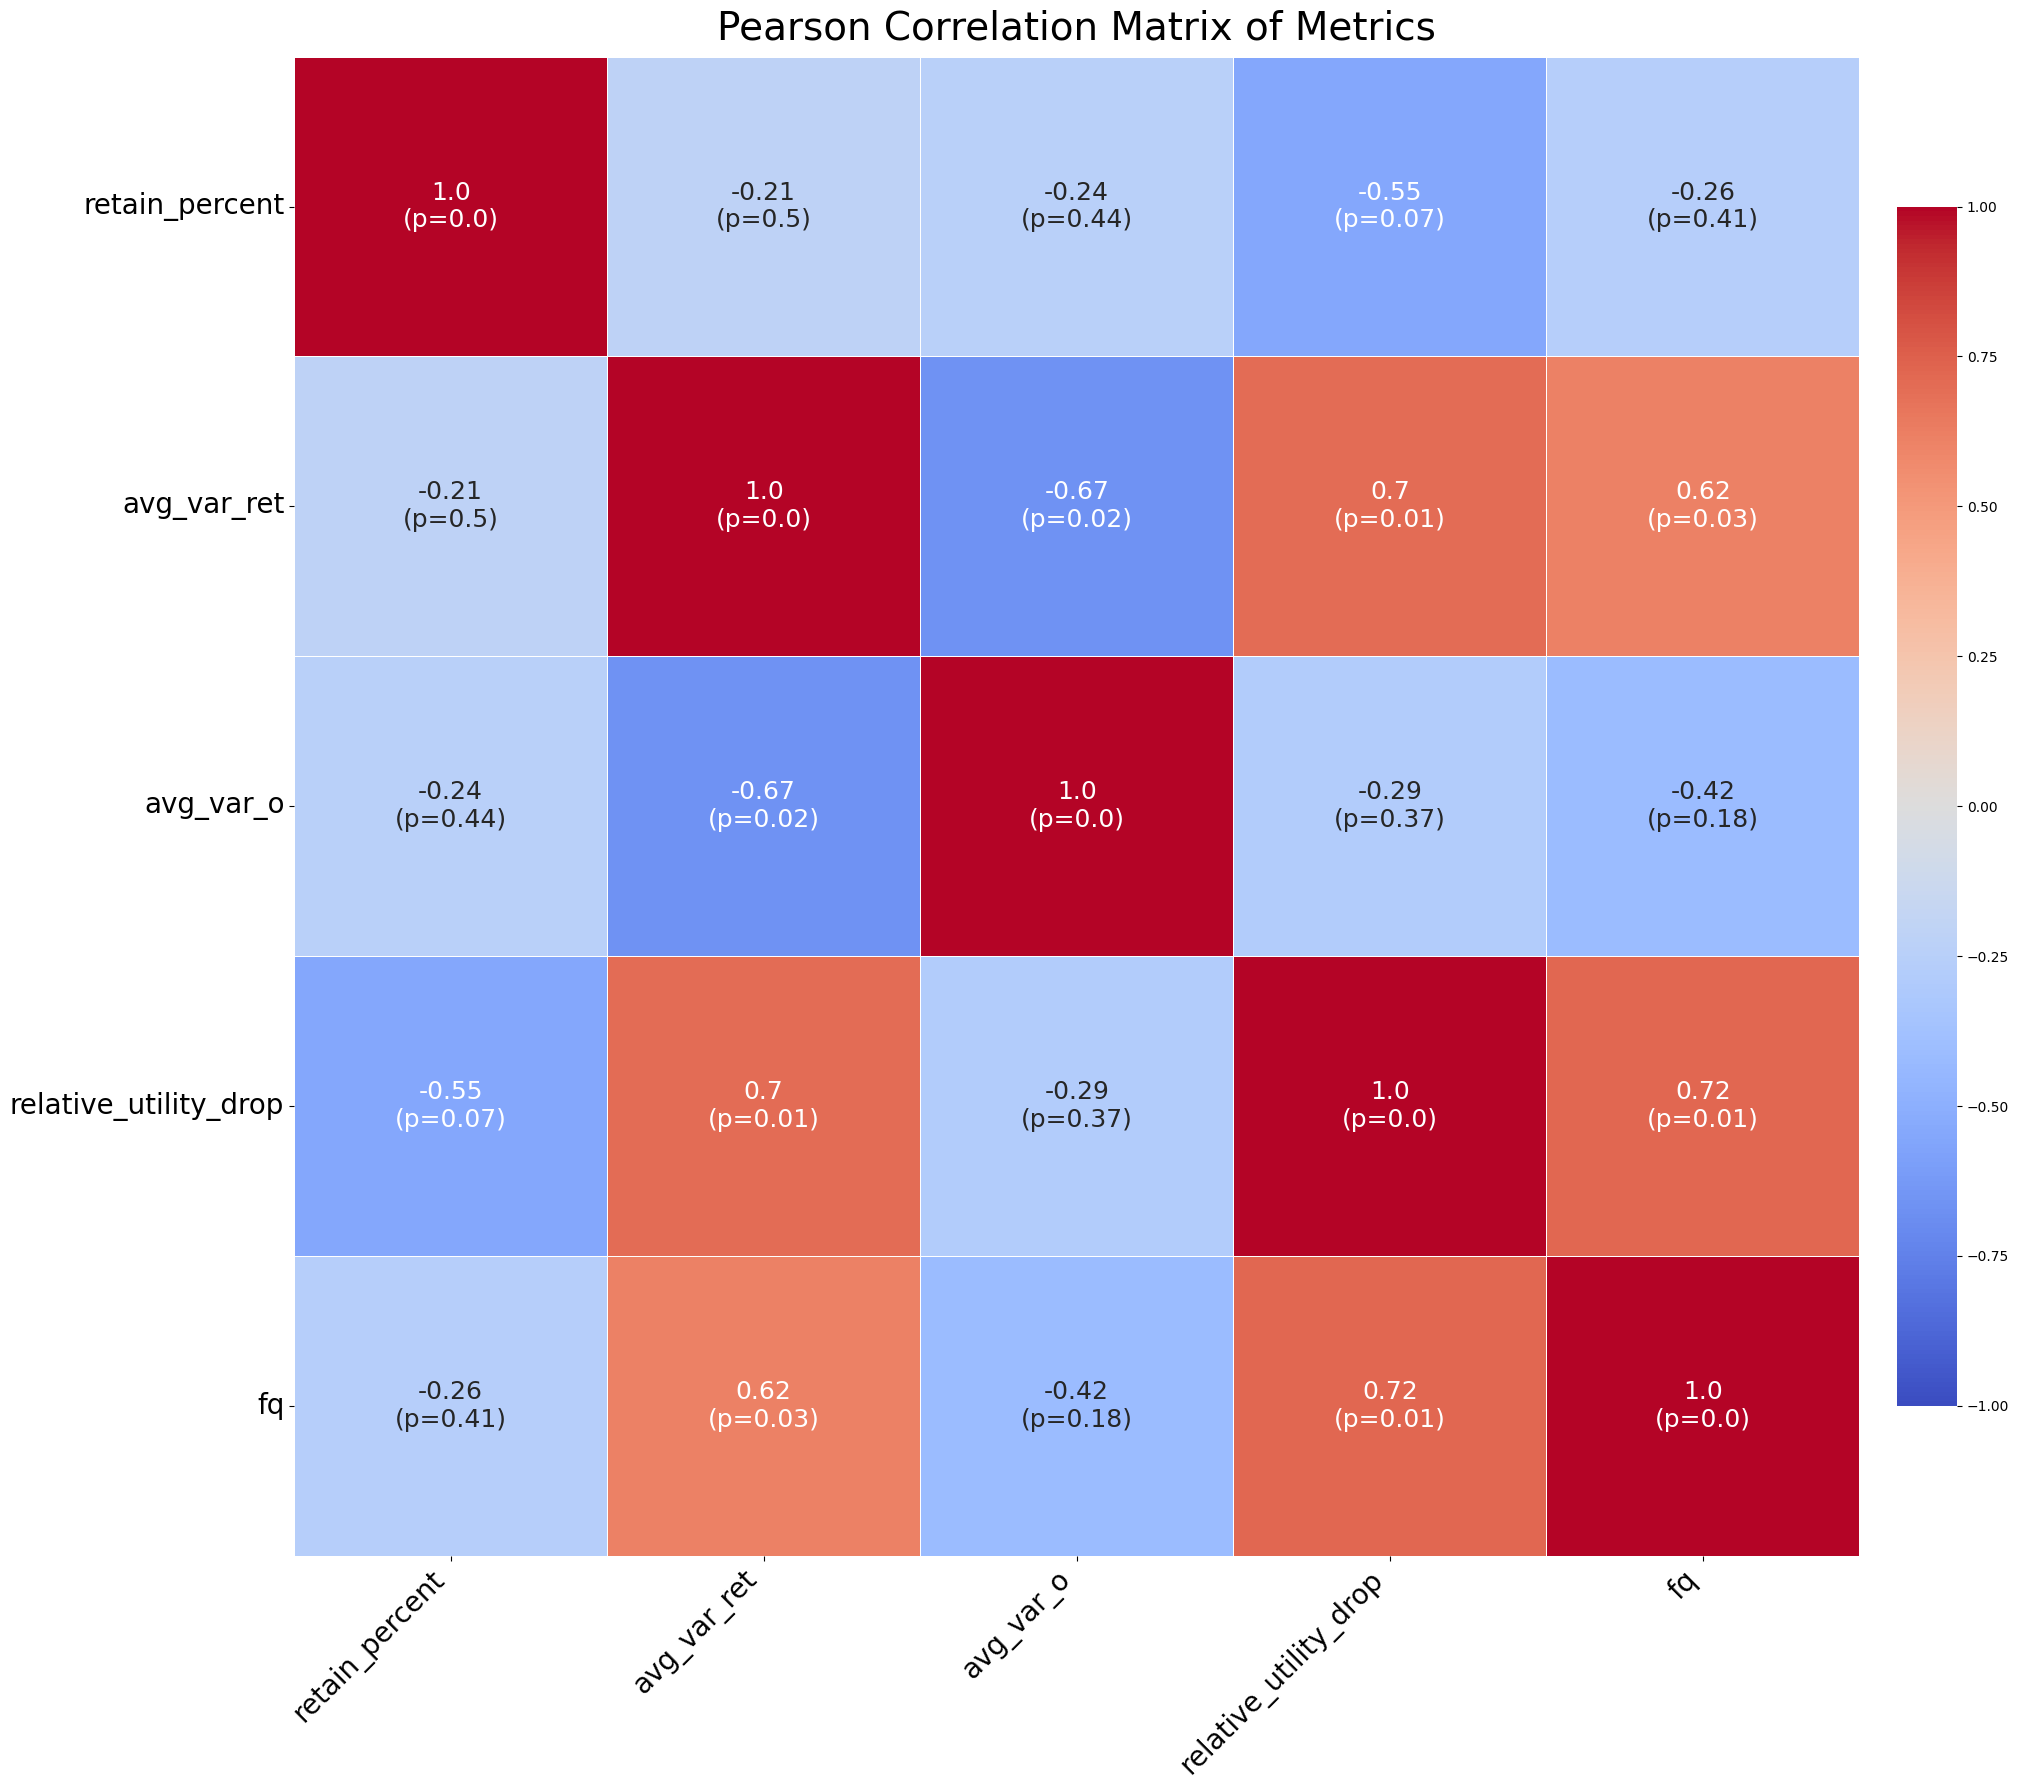

In [ ]:
pearson_annot = (
    pearson_corr_matrix.round(2).astype(str)
    + "\n(p=" + pearson_p_matrix.round(2).astype(str) + ")"
)

fig, ax = plt.subplots(figsize=(22, 18))  # a bit larger than before
sns.heatmap(
    pearson_corr_matrix,
    cmap="coolwarm", vmin=-1, vmax=1,
    annot=pearson_annot.values,  # pass the array of strings
    fmt="",                       # important when annot already contains strings
    annot_kws={"fontsize": 18},   # larger text
    linewidths=0.5, linecolor="white",
    cbar_kws={"shrink": 0.8, "pad": 0.02},
    ax=ax,
)

ax.set_title("Pearson Correlation Matrix of Metrics", fontsize=28, pad=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=20)

plt.tight_layout()
plt.savefig("./images/pearson_mix_without_semsyn2.pdf", bbox_inches="tight")
plt.show()

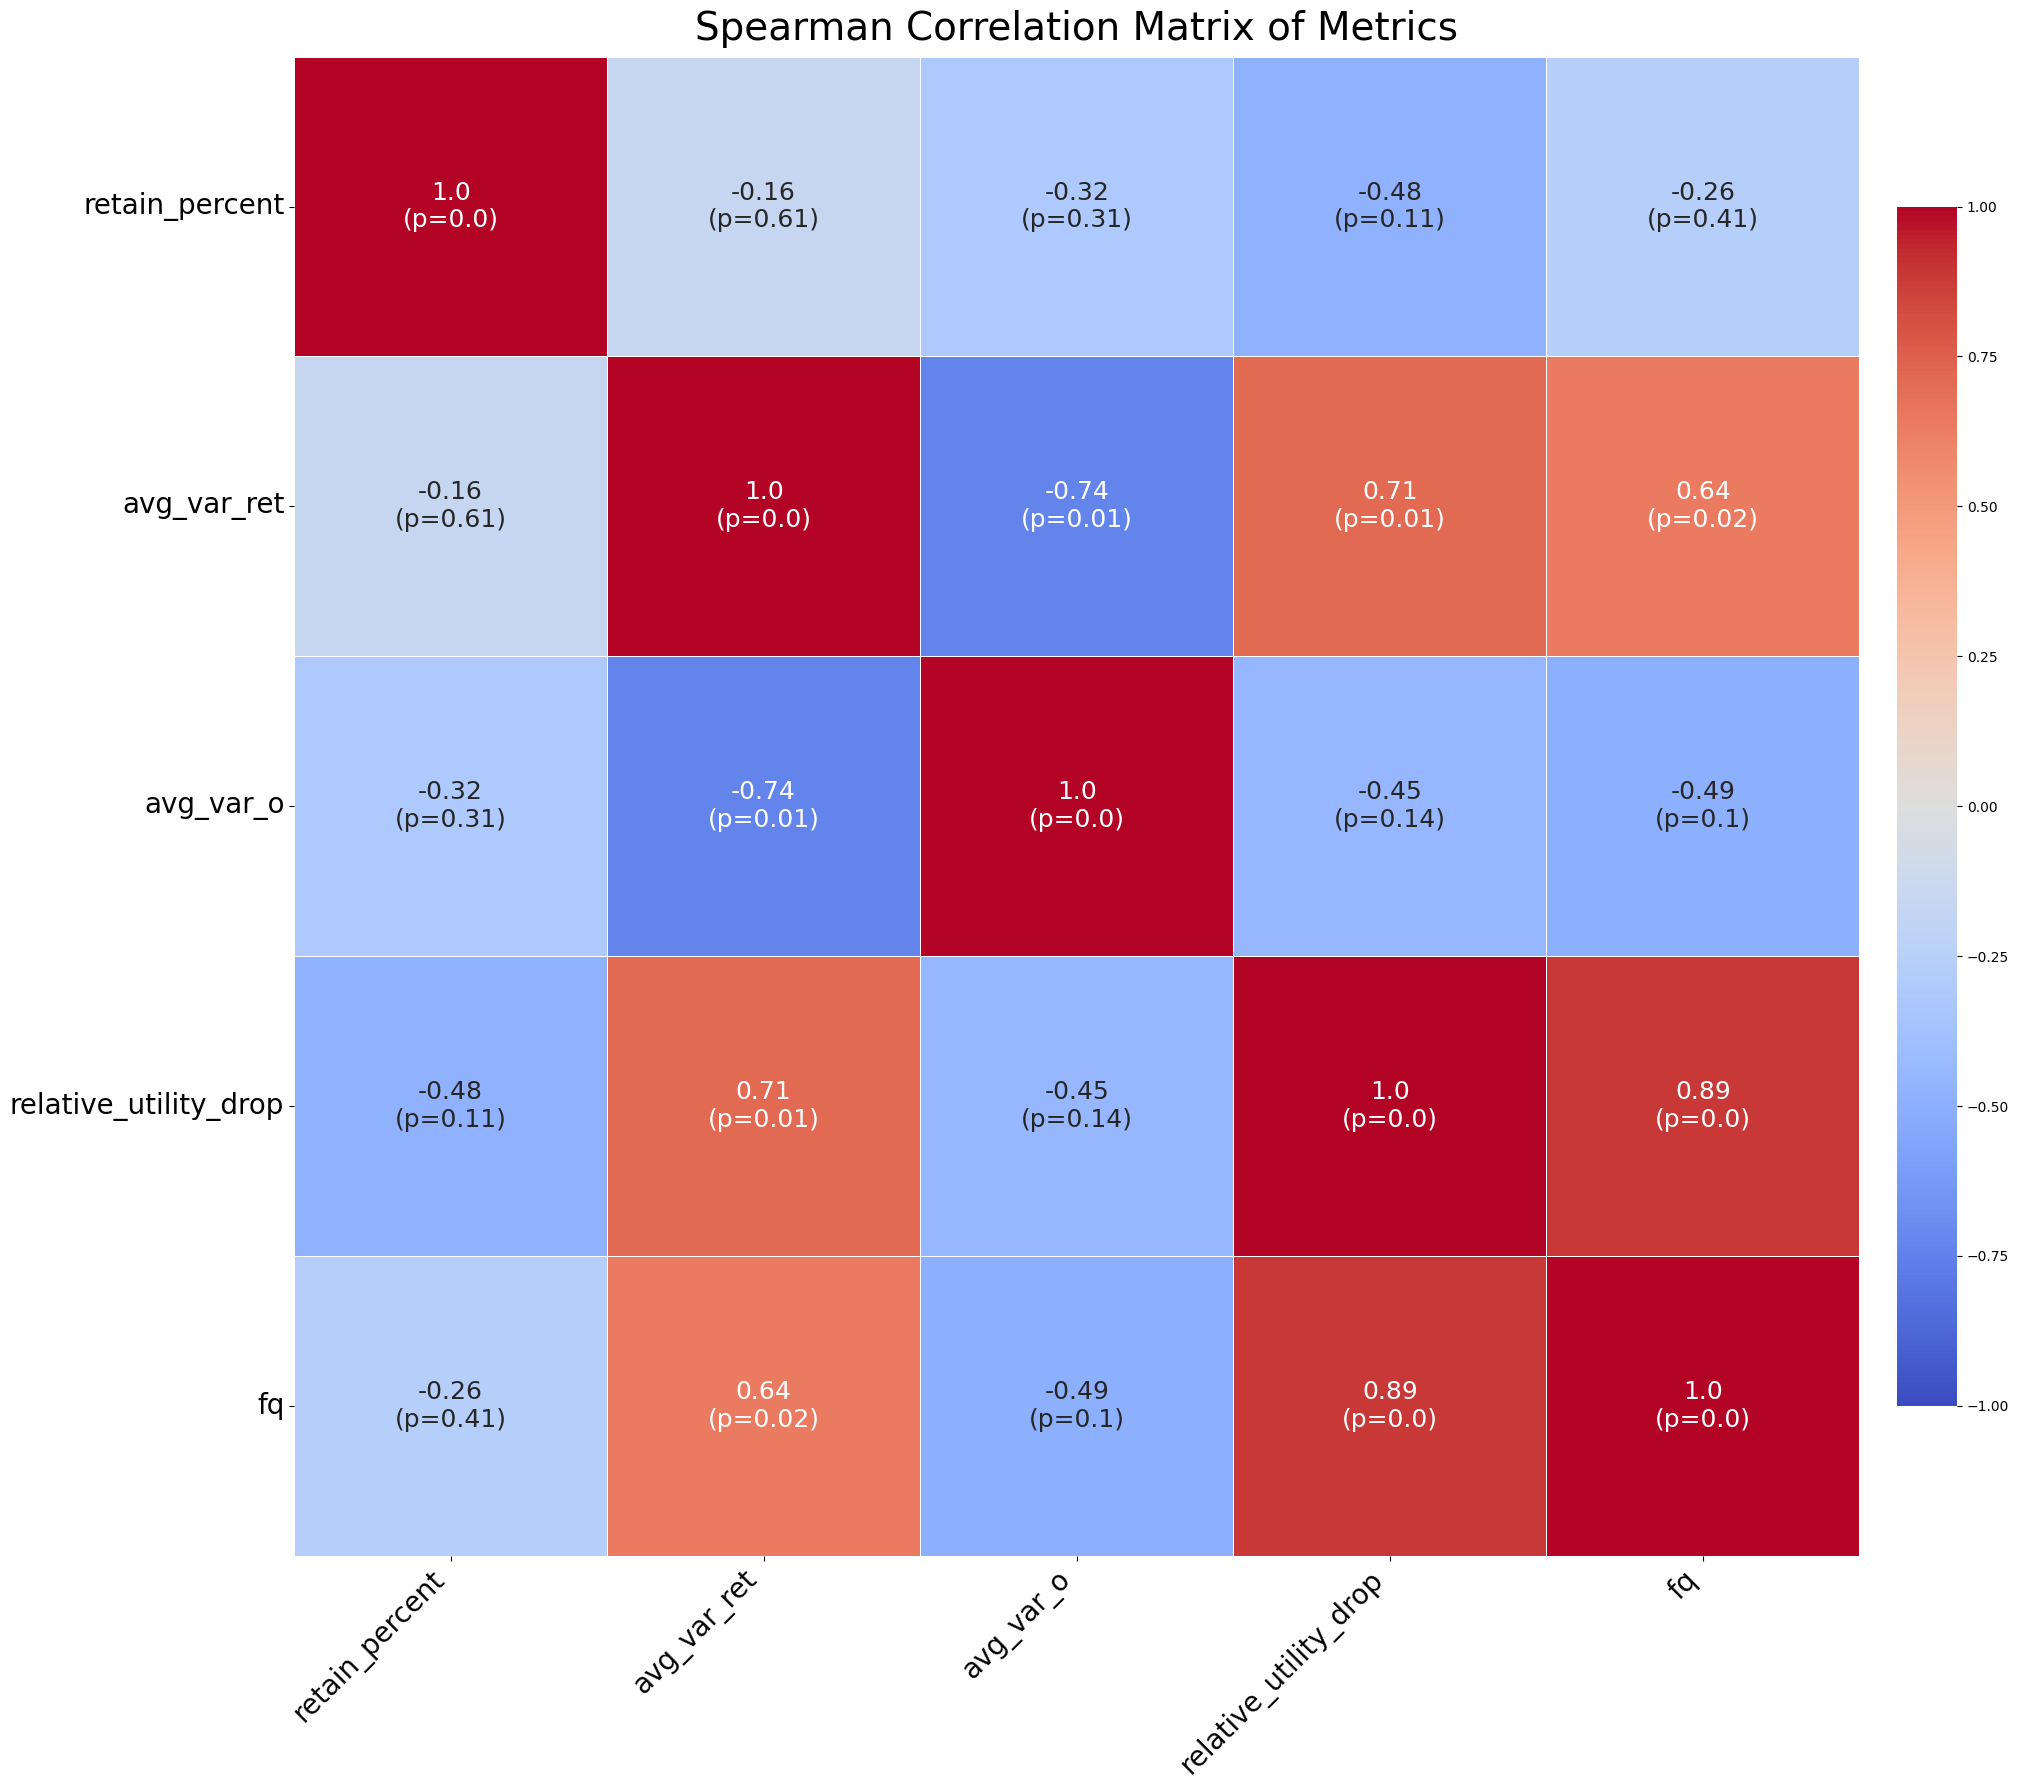

In [ ]:
spearman_annot = (
    spearman_corr_matrix.round(2).astype(str)
    + "\n(p=" + spearman_p_matrix.round(2).astype(str) + ")"
)

fig, ax = plt.subplots(figsize=(22, 18))  # large figure for readability
sns.heatmap(
    spearman_corr_matrix,
    cmap="coolwarm", vmin=-1, vmax=1,
    annot=spearman_annot.values,  # array of strings
    fmt="",                       # must be empty when annotations are strings
    annot_kws={"fontsize": 18},   # larger annotation text
    linewidths=0.5, linecolor="white",
    cbar_kws={"shrink": 0.8, "pad": 0.02},
    ax=ax,
)

ax.set_title("Spearman Correlation Matrix of Metrics", fontsize=28, pad=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=20)

plt.tight_layout()
plt.savefig("./images/spearman_mix_without_semsyn2.pdf", bbox_inches="tight")
plt.show()

In [50]:
# Target variable for correlation
target_var = 'relative_utility_drop'

# Get the list of features to correlate with the target
features = cols_to_correlate.drop(target_var)

# Extract the correlation and p-values for the target variable
pearson_corrs = pearson_corr_matrix.loc[features, target_var]
pearson_ps = pearson_p_matrix.loc[features, target_var]
spearman_corrs = spearman_corr_matrix.loc[features, target_var]
spearman_ps = spearman_p_matrix.loc[features, target_var]

# Create a summary DataFrame
correlation_summary = pd.DataFrame({
    'Pearson Correlation': pearson_corrs,
    'Pearson p-value': pearson_ps,
    'Spearman Correlation': spearman_corrs,
    'Spearman p-value': spearman_ps
})

# Sort by the absolute value of Pearson correlation for better interpretation
correlation_summary['Abs Pearson Correlation'] = correlation_summary['Pearson Correlation'].abs()
correlation_summary = correlation_summary.sort_values(by='Abs Pearson Correlation', ascending=False).drop(columns=['Abs Pearson Correlation'])

# Display the formatted table
print(f"Correlations with '{target_var}':\n")
correlation_summary.style.format({
    'Pearson Correlation': '{:.3f}',
    'Pearson p-value': '{:.3f}',
    'Spearman Correlation': '{:.3f}',
    'Spearman p-value': '{:.3f}'
})

Correlations with 'relative_utility_drop':



,Pearson Correlation,Pearson p-value,Spearman Correlation,Spearman p-value
fq,0.724,0.008,0.885,0.000
avg_var_ret,0.698,0.012,0.666,0.018
retain_percent,-0.547,0.065,-0.483,0.112
contamination_score,0.287,0.365,0.074,0.820
avg_var_o,-0.264,0.406,-0.441,0.151


### with sem and syn

In [ ]:
LOG_CSV   = "unlearning_metrics_mix_semsyn.csv"
LOG_JSONL = "unlearning_metrics_mix_semsyn.jsonl"

In [ ]:
row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/grand/grad_difference/diff_20.csv", 
                                             ret_id="diff_20", data = "mix",
                                             fq = 0.93,
                                             new_utility=0.50)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/grand/grad_difference/diff_10.csv", 
                                             ret_id="diff_10", data = "mix",
                                             fq = 0.95,
                                             new_utility=0.40)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/grand/grad_difference/diff_5.csv", 
                                             ret_id="diff_5", data = "mix",
                                             fq = 0.95,
                                             new_utility=0.21)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/grand/grad_descent/desc_20.csv", 
                                             ret_id="desc_20", data = "mix",
                                             fq = 0.94,
                                             new_utility=0.46)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/grand/grad_descent/desc_10.csv", 
                                             ret_id="desc_10", data = "mix",
                                             fq = 0.95,
                                             new_utility=0.35)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/grand/grad_descent/desc_5.csv", 
                                             ret_id="desc_5", data = "mix",
                                             fq = 0.94,
                                             new_utility=0.13)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/moderate/mod_5.csv", 
                                             ret_id="mod_5", data = "mix",
                                             fq = 0.94,
                                             new_utility=0.41)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/moderate/mod_10.csv", 
                                             ret_id="mod_10", data = "mix",
                                             fq = 0.93,
                                             new_utility=0.49)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/moderate/mod_20.csv", 
                                             ret_id="mod_20", data = "mix",
                                             fq = 0.93,
                                             new_utility=0.58)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/random/random_5.csv", 
                                             ret_id="random_5", data = "mix",
                                             fq = 0.92,
                                             new_utility=0.59)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/random/random_10.csv", 
                                             ret_id="random_10", data = "mix",
                                             fq = 0.93,
                                             new_utility=0.50)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/random/random_20.csv", 
                                             ret_id="random_20", data = "mix",
                                             fq = 0.93,
                                             new_utility=0.55)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/semantic/semantic_5.csv", 
                                             ret_id="semantic_5", data = "unified",
                                             fq = 0.94,
                                             new_utility=0.21)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/semantic/semantic_10.csv", 
                                             ret_id="semantic_10", data = "unified",
                                             fq = 0.91,
                                             new_utility=0.59)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/semantic/semantic_20.csv", 
                                             ret_id="semantic_20", data = "unified",
                                             fq = 0.92,
                                             new_utility=0.66)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/syntactic/syntactic_5.csv", 
                                             ret_id="syntactic_5", data = "unified",
                                             fq = 0.93,
                                             new_utility=0.17)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/syntactic/syntactic_10.csv", 
                                             ret_id="syntactic_10", data = "unified",
                                             fq = 0.94,
                                             new_utility=0.35)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/mix/coresets/syntactic/syntactic_20.csv", 
                                             ret_id="syntactic_20", data = "unified",
                                             fq = 0.94,
                                             new_utility=0.63)

type2
other       16635
retain       4158
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.2869 seconds!
type2
other       18714
retain       2079
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0666 seconds!
type2
other       19754
retain       1039
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0656 seconds!


/tmp/ipykernel_688219/1264738245.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([row])], ignore_index=True)


type2
other       16635
retain       4158
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0655 seconds!
type2
other       18714
retain       2079
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0709 seconds!
type2
other       19754
retain       1039
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0655 seconds!
type2
other       19756
retain       1037
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0654 seconds!
type2
other       18716
retain       2077
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0672 seconds!
type2
other       16637
retain       4156
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0654 seconds!
type2
other       19753
retain       1040
forget_1       98
Name: count, dtype: int64
Variance calculation took: 0.0659 seconds!
type2
other       18714
retain       2079
forget_1       98
Name: count, dtype: int64
Variance ca

In [53]:
def get_metrics_df(csv_path: str = LOG_CSV) -> pd.DataFrame:
    """Convenience: load the whole metrics log as a DataFrame for analysis."""
    if not os.path.exists(csv_path):
        return pd.DataFrame()
    return pd.read_csv(csv_path)

In [59]:
metrics2 = get_metrics_df()

In [60]:
metrics2['ret_id'].unique()

array(['diff_20', 'diff_10', 'diff_5', 'desc_20', 'desc_10', 'desc_5',
       'mod_5', 'mod_10', 'mod_20', 'random_5', 'random_10', 'random_20',
       'semantic_5', 'semantic_10', 'semantic_20', 'syntactic_5',
       'syntactic_10', 'syntactic_20'], dtype=object)

In [61]:
cols_to_correlate = metrics2.columns.drop(['dataset', 'ret_id', 'baseline_utility', 'forget_percent', 'total_len', 'avg_var_full', 'avg_var_f', 'new_utility', 'ret_len'])

# Initialize matrices for Pearson correlations and p-values
pearson_corr_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                   index=cols_to_correlate, columns=cols_to_correlate)
pearson_p_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                index=cols_to_correlate, columns=cols_to_correlate)

# Initialize matrices for Spearman correlations and p-values
spearman_corr_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                    index=cols_to_correlate, columns=cols_to_correlate)
spearman_p_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                 index=cols_to_correlate, columns=cols_to_correlate)

# Calculate correlations and p-values
for col1 in cols_to_correlate:
    for col2 in cols_to_correlate:
        # Pearson
        pearson_corr, pearson_p = pearsonr(metrics2[col1], metrics2[col2])
        pearson_corr_matrix.loc[col1, col2] = pearson_corr
        pearson_p_matrix.loc[col1, col2] = pearson_p
        
        # Spearman
        spearman_corr, spearman_p = spearmanr(metrics2[col1], metrics2[col2])
        spearman_corr_matrix.loc[col1, col2] = spearman_corr
        spearman_p_matrix.loc[col1, col2] = spearman_p


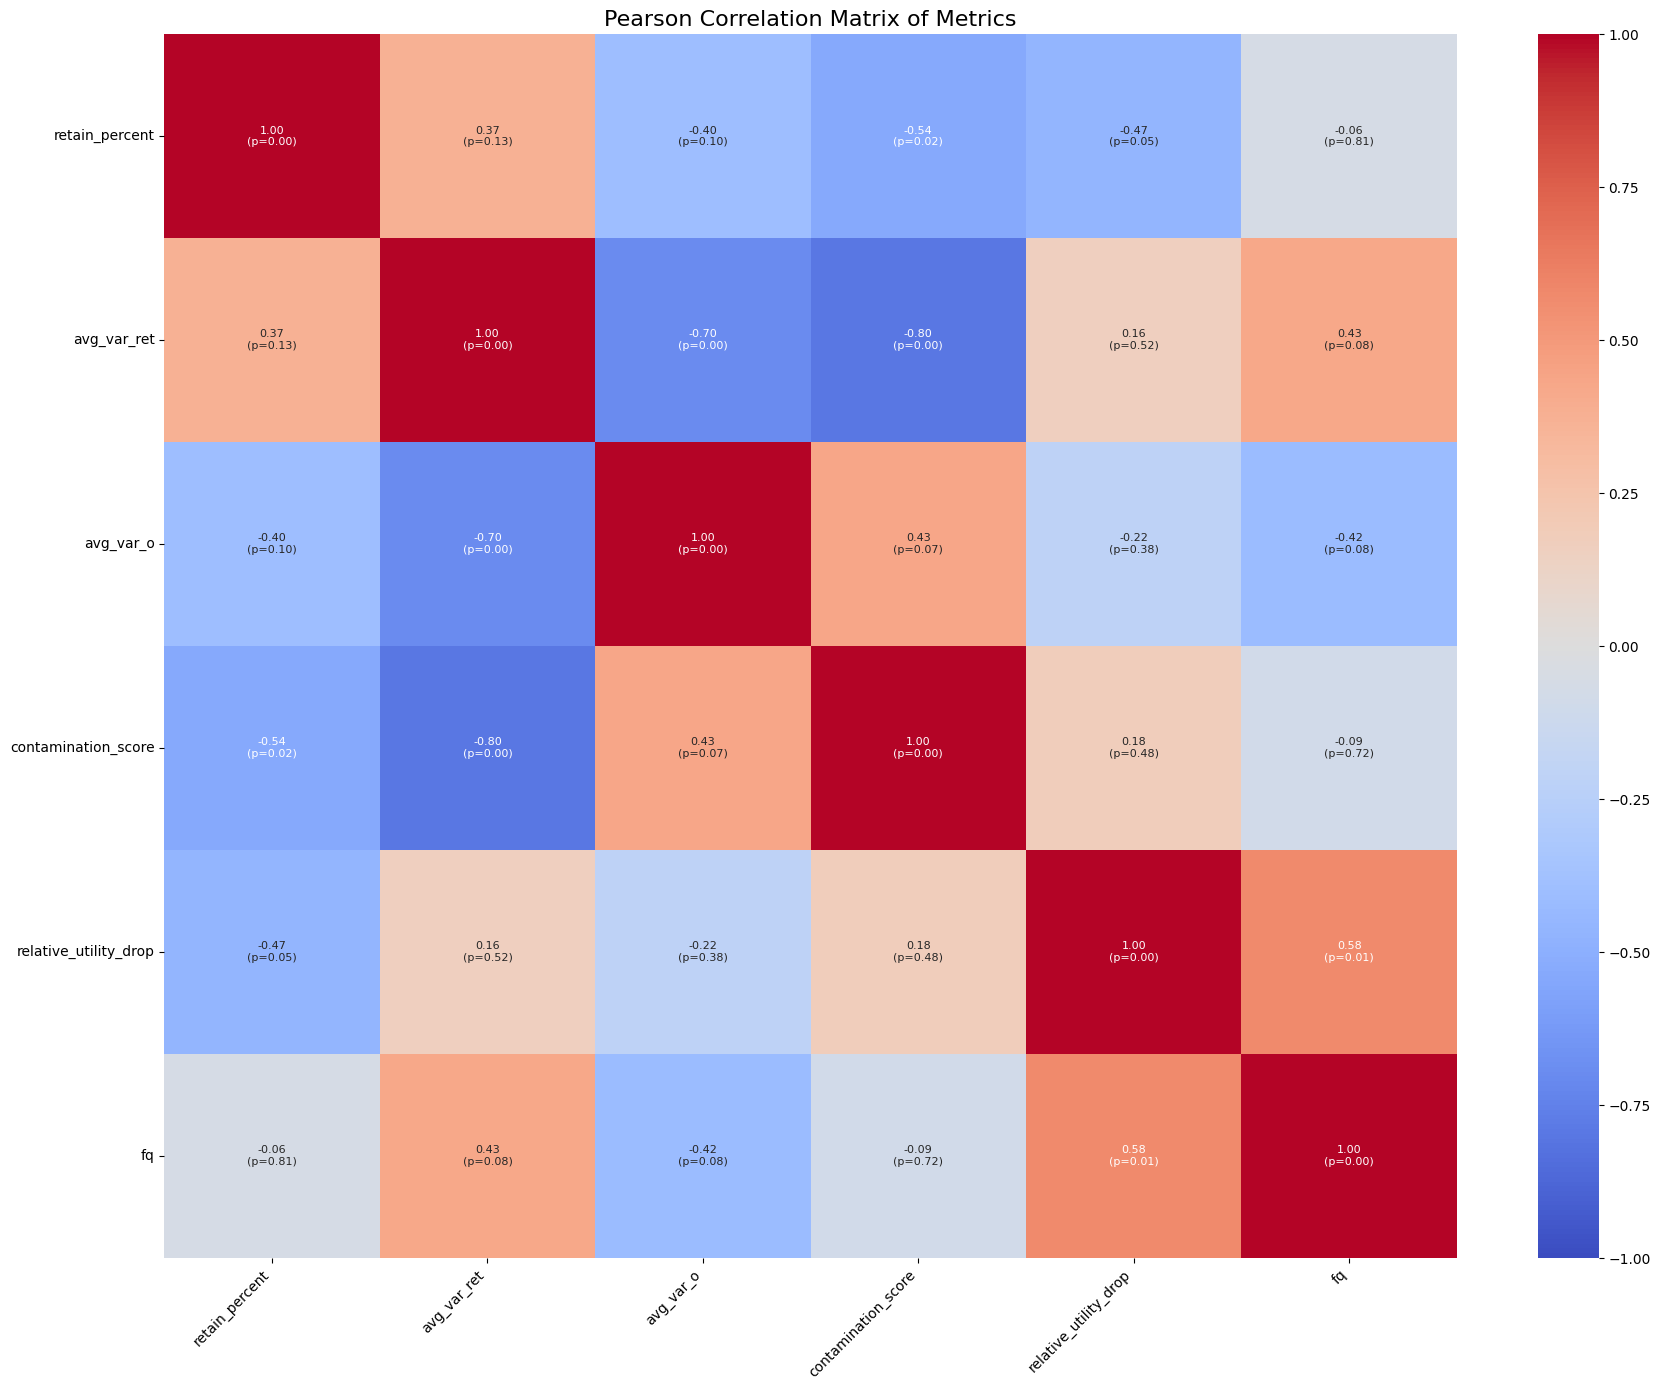

In [ ]:
pearson_annot = pearson_corr_matrix.map('{:.2f}'.format) + '\n(p=' + pearson_p_matrix.map('{:.2f}'.format) + ')'

plt.figure(figsize=(18, 14))
sns.heatmap(pearson_corr_matrix, annot=pearson_annot, fmt='s', cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title('Pearson Correlation Matrix of Metrics', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./images/pearson_mix_with_semsyn.pdf', bbox_inches='tight')
plt.show()

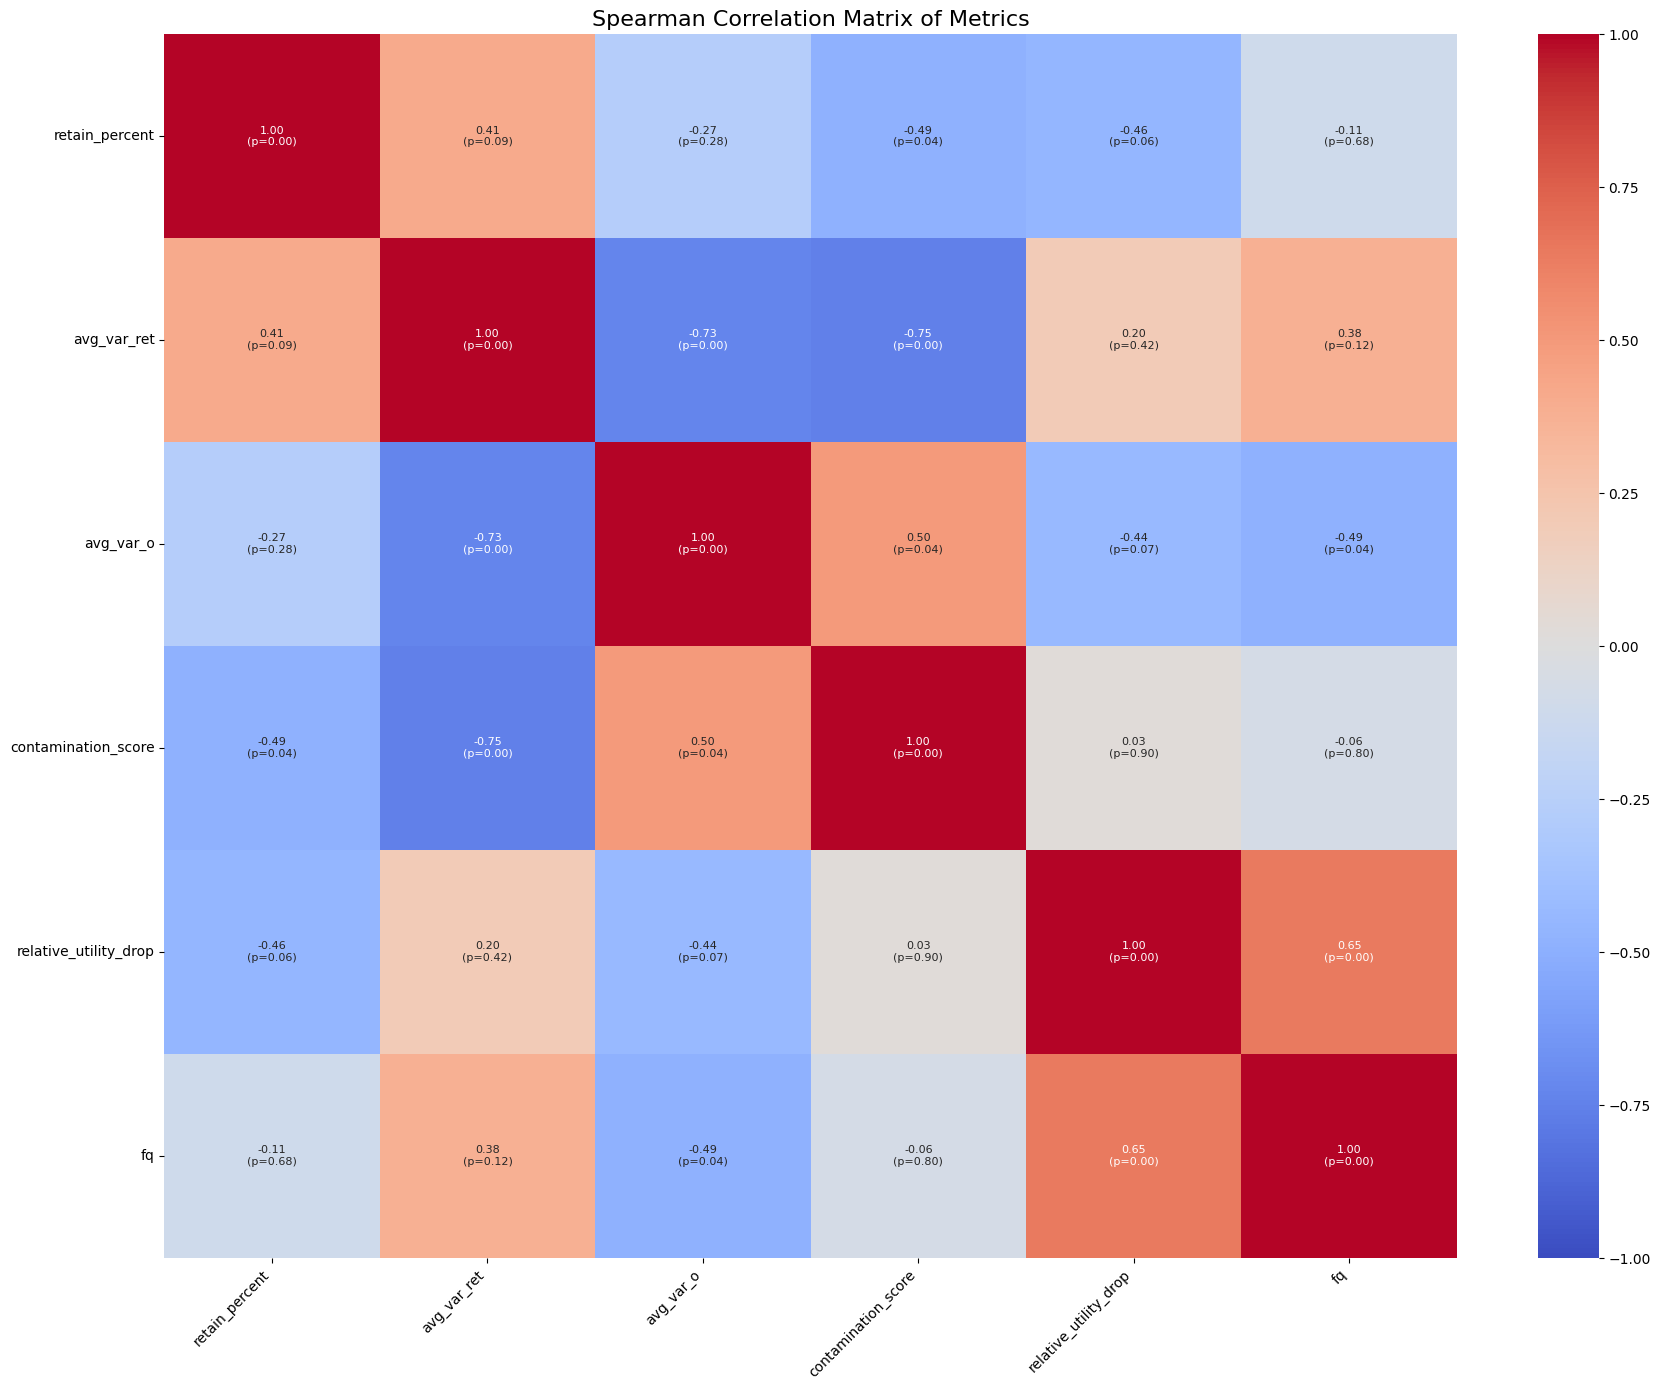

In [ ]:
spearman_annot = spearman_corr_matrix.map('{:.2f}'.format) + '\n(p=' + spearman_p_matrix.map('{:.2f}'.format) + ')'

plt.figure(figsize=(18, 14))
sns.heatmap(spearman_corr_matrix, annot=spearman_annot, fmt='s', cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title('Spearman Correlation Matrix of Metrics', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./images/spearman_mix_with_semsyn.pdf', bbox_inches='tight')
plt.show()

### preference ratio calculation

In [22]:
EPS = 1e-12

In [23]:
def make_pool_baseline(df_full, clusters):
    """Compute q_pool from the full dataset (fixed across experiments).
       Exclude 'forget' from the selectable pool baseline."""
    pool = df_full[df_full["type2"] != "forget_1"]
    pool_count = pool.groupby("cluster").size().reindex(clusters, fill_value=0)
    pool_total = int(pool_count.sum())
    q_pool = (pool_count / max(pool_total, 1)).astype(float)
    return pool_count, pool_total, q_pool

In [31]:
def get_pref_ratio(df, method, q_pool, pool_count, pool_total, clusters, dataset,
                         mu_on="non_forget"):
    """
    df_exp is the experiment-specific df AFTER you assign type2 for (method, percent).
    Adds per-cluster FE, MU, and cluster-local variance terms alongside preference stats.
    """
    #df = get_df(df, ret_path)
    vc = df['type2'].value_counts(normalize=True)
    print(df['type2'].value_counts())
    forget_percent = _safe_percent(vc, 'forget_1')
    retain_percent = _safe_percent(vc, 'retain')
    # retain distribution
    retain_mask = (df["type2"] == "retain")
    retain_counts = (
        df.loc[retain_mask]
              .groupby("cluster")
              .size()
              .reindex(clusters, fill_value=0)
    )
    retain_total = int(retain_counts.sum())
    p_retain = (retain_counts / max(retain_total, 1)).astype(float)

    # preference & log2
    pref_ratio = (p_retain.values + EPS) / (q_pool.values + EPS)
    pref_log2 = np.log2(pref_ratio)


    rows = []
    label = f"{method} | {retain_percent}%"

    for idx, c in enumerate(clusters):
        df_c = df[df["cluster"] == c]
        #avg_var_ret, avg_var_f, avg_var_o, avg_var_full = get_variance(df_c)
        rows.append({
            "method": method,
            "dataset": dataset,
            "retain_pct": int(retain_percent),
            "label": label,
            "cluster": int(c),

            "retain_count": int(retain_counts.values[idx]),
            "retain_total": int(retain_total),
            "p_retain": float(p_retain.values[idx]),
            "pool_count": int(pool_count.values[idx]),
            "pool_total": int(pool_total),
            "q_pool": float(q_pool.values[idx]),
            "pref_ratio": float(pref_ratio[idx]),
            "pref_log2": float(pref_log2[idx]),

            })
    return pd.DataFrame(rows)

In [ ]:
clusters = list(range(10))  # 0..9
df = get_df(df, ret_path="./data/mix/coresets/grand/grad_difference/diff_20.csv")
pool_count, pool_total, q_pool = make_pool_baseline(df, clusters)
pool_count, pool_total, q_pool

(cluster
 0    3308
 1    1389
 2    2521
 3    2636
 4     838
 5    3394
 6    2123
 7     622
 8    1520
 9    2442
 dtype: int64,
 20793,
 cluster
 0    0.159092
 1    0.066801
 2    0.121243
 3    0.126773
 4    0.040302
 5    0.163228
 6    0.102102
 7    0.029914
 8    0.073102
 9    0.117443
 dtype: float64)

In [ ]:
results = []

df = get_df(df, ret_path="./data/mix/coresets/grand/grad_difference/diff_5.csv")
results.append(
    get_pref_ratio(df, method="grand(diff)_5",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/grand/grad_difference/diff_20.csv")
results.append(
    get_pref_ratio(df, method="grand(diff)_10",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/grand/grad_difference/diff_20.csv")
results.append(
    get_pref_ratio(df, method="grand(diff)_20",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/grand/grad_descent/desc_5.csv")
results.append(
    get_pref_ratio(df, method="grand(CE)_5",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/grand/grad_descent/desc_20.csv")
results.append(
    get_pref_ratio(df, method="grand(CE)_10",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/grand/grad_descent/desc_20.csv")
results.append(
    get_pref_ratio(df, method="grand(CE)_20",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/moderate/mod_5.csv")
results.append(
    get_pref_ratio(df, method="moderate_5",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/moderate/mod_20.csv")
results.append(
    get_pref_ratio(df, method="moderate_10",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/moderate/mod_20.csv")
results.append(
    get_pref_ratio(df, method="moderate_20",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/random/random_5.csv")
results.append(
    get_pref_ratio(df, method="random_5",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/random/random_10.csv")
results.append(
    get_pref_ratio(df, method="random_10",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/random/random_20.csv")
results.append(
    get_pref_ratio(df, method="random_20",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/semantic/semantic_5.csv")
results.append(
    get_pref_ratio(df, method="semantic_5",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/semantic/semantic_10.csv")
results.append(
    get_pref_ratio(df, method="semantic_10",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/semantic/semantic_20.csv")
results.append(
    get_pref_ratio(df, method="semantic_20",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/syntactic/syntactic_5.csv")
results.append(
    get_pref_ratio(df, method="syntactic_5",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/syntactic/syntactic_10.csv")
results.append(
    get_pref_ratio(df, method="syntactic_10",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

df = get_df(df, ret_path="./data/mix/coresets/syntactic/syntactic_20.csv")
results.append(
    get_pref_ratio(df, method="syntactic_20",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'mix')
)

results_df = pd.concat(results, ignore_index=True)

type2
other       19754
retain       1039
forget_1       98
Name: count, dtype: int64
type2
other       18714
retain       2079
forget_1       98
Name: count, dtype: int64
type2
other       16635
retain       4158
forget_1       98
Name: count, dtype: int64
type2
other       19754
retain       1039
forget_1       98
Name: count, dtype: int64
type2
other       18714
retain       2079
forget_1       98
Name: count, dtype: int64
type2
other       16635
retain       4158
forget_1       98
Name: count, dtype: int64
type2
other       19756
retain       1037
forget_1       98
Name: count, dtype: int64
type2
other       18716
retain       2077
forget_1       98
Name: count, dtype: int64
type2
other       16637
retain       4156
forget_1       98
Name: count, dtype: int64
type2
other       19753
retain       1040
forget_1       98
Name: count, dtype: int64
type2
other       18714
retain       2079
forget_1       98
Name: count, dtype: int64
type2
other       16634
retain       4159
forget_1    

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='method', ylabel='cluster'>

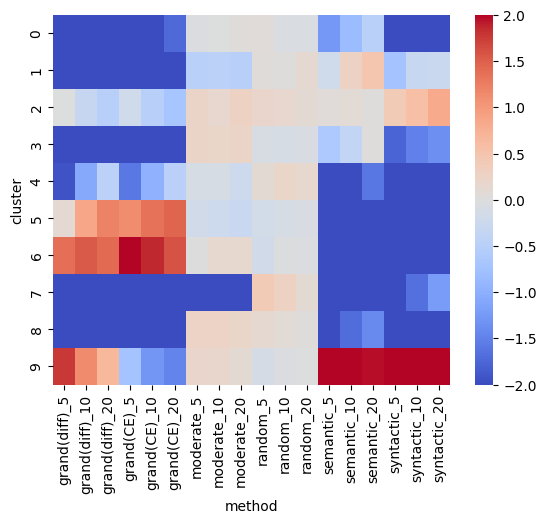

In [46]:
heat = results_df.pivot(index="cluster", columns="method", values="pref_log2")

method_order = ["Random","Moderate","Grand(desc)","Grand(diff)"]
col_order = (results_df[["method"]]
             .drop_duplicates()
             .sort_values(by=["method"], key=lambda s: s.map(
                 {m:i for i,m in enumerate(method_order)} if s.name=="method" else s))["method"].tolist())
heat = heat.reindex(columns=col_order)
sns.heatmap(heat, center=0.0, cmap="coolwarm", vmin=-2, vmax=2)

In [ ]:
heat = results_df.pivot(index="cluster", columns="method", values="pref_log2")

method_order = ["Random","Moderate","Grand(desc)","Grand(diff)"]
col_order = (results_df[["method"]]
             .drop_duplicates()
             .sort_values(by=["method"], key=lambda s: s.map(
                 {m:i for i,m in enumerate(method_order)} if s.name=="method" else s))["method"].tolist())
heat = heat.reindex(columns=col_order)
ax = sns.heatmap(heat, center=0.0, cmap="coolwarm", vmin=-2, vmax=2)
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("./images/mix_pref_log2.pdf", bbox_inches="tight")
plt.close(fig)

In [ ]:
results_df.to_csv('mix_pref_log2.csv', index = False)